# Ground States: Imaginary Time Evolution
## Category: Prerequisites
## Prerequisites: Quantum Harmonic Oscillator, Time Evolution: Split Operator, Quantum Mechanics
## Author: Christina Lee

I've long thought that instead of being called the imaginary number, $i$ should be called the magic number. For many tricky problems, I feel like I can almost just throw $i$ at the problem and then the problem solves itself.  Once again, $i$ performs unexpected wonders when we perform <i>analytic continuation</i> of the time variable into the complex plane.  

<i>Analytic continuation</i> is when we take a variable limited to the Real $\mathbb{R}$ axis and allow it to take on all values in the complex plane $\mathbb{C}$.

In the Split Operator post, we saw one computational method of performing time evolution. If you haven't read that, I recommend perusing it before trying the parse the code here. Split Operator is just one method; other methods include Green's functions and semi-classical molecular dynamics. Imaginary time evolution would equally apply to any other time evolution method.

Given the Split Operator Method, we can evolve any wavefunction we want. But what wavefunction do we evolve?

In the previous post, I just used a variation on an exactly solvable problem,  allowing me to plug in an exact solution.  However, I won't always be able to do that, given the minimal number of exact solutions in Quantum Mechanics. Imaginary time allows us to determine the lowest energy eigenstate, or ground state, of just about any Hamiltonian.  In cold atomic physics, we usually care most about the ground state, and this method provides a robust method of determining it.

So how does imaginary time in Quantum Mechanics work? We can write  any arbitrary wavefunction as a superposition of eigenstates,
$$
\Psi = \sum_i a_i \phi_i .
$$
Each eigenstate doesn't change in overall magnitude as time progresses but rotates with a frequency proportional to the energy.  The superposition changes from a changing interference pattern,
$$
\Psi (t) = \sum_i a_i (0) e^{-i E_i t} \phi_i .
$$

If we now perform the substitution $(t \mapsto -i t)$
$$
\Psi (-it) = \sum_i a_i (0) e^{- E_i t} \phi_i,
$$
we can see that all eigenstates dissipate away in an imaginary time system, but the states with higher energy dissipate more rapidly.  Over time, the lowest energy state comes to dominate the wavefunction. 

This trick is called a [Wick rotation](https://en.wikipedia.org/wiki/Wick_rotation).  Wick rotations are also used to equate inverse temperature $1/T$ with imaginary time $i t$ to statistical quantum mechanics problems or to solve problems in cosmology.  



## Coding Time!

Let's load our packages:

In [1]:
using FFTW
using Plots
gr()

┌ Info: Recompiling stale cache file /home/shaula/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1187


Plots.GRBackend()

## Parameters
This code just needs to run long enough to get decent convergence.  Make sure to have small enough steps in space and time.

In [2]:
# Set Time Parameters
t0=0
tf=5
dt=.01

# Set Space Grid Parameters 
dx=.05
xmax=6
# xmin will be -xmax.  Making the situation symmetric


6

In [3]:
t=collect(t0:dt:tf)
x=collect(-xmax:dx:xmax)

nt=length(t)
N=length(x)

dk=2*π/(N*dx)
if iseven(N) 
    k[collect(0:N/2) ; collect(-N/2:-1)]*dk
    else # N is odd
    k=[collect(0:(N-1)/2) ; collect(-(N-1)/2:-1)]*dk
end;

In the next cell, we define our evolution operators.

This cell holds the key differences between standard time evolution and imaginary time evolution.  Note the absence of $i$ in the definition of the evolution operators.

In [4]:
Vx=.5*x.^2;
Vk=.5*k.^2

Uxh=exp.(-Vx*dt/2);
Ux=exp.(-Vx*dt);
Uf=exp.(-Vk*dt);
"potentials and evolvers defined"

"potentials and evolvers defined"

To see the decay to the ground state, we will check the overlap with some higher energy harmonic oscillator eigenstates.

In [5]:
ϕ(x)=π^(-.25)*exp(-x.^2/2)
ϕ1(x)=sqrt(2)*π^(-.25)*exp(-x.^2/2)*x
ϕ2(x)=1/sqrt(2)*π^(-.25)*exp(-x.^2/2)*(2*x^2-1)
ϕ4(x)=1/(2*sqrt(6)*π^(.25))*exp(-x.^2/2)*(4*x^4-12*x^2+3)

ϕ4 (generic function with 1 method)

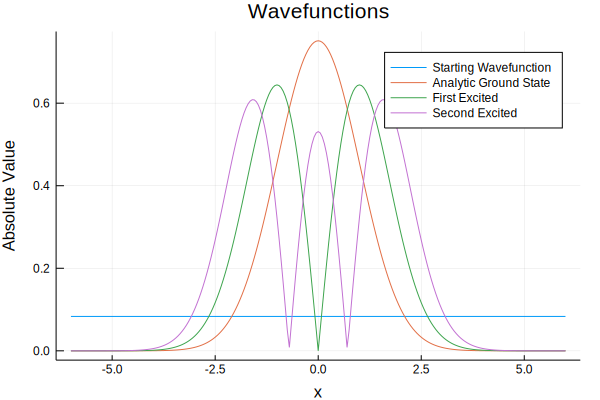

In [6]:
Ψ0=(1.0/(2*xmax))*ones(Complex{Float64},N);
Ψtrue=(1+0*im).*ϕ.(x);
fΨtrue=fft(Ψtrue);
Ψ1=(1+0*im).*ϕ1.(x);
Ψ2=(1+0*im).*ϕ2.(x);
Ψ4=(1+0*im).*ϕ4.(x);

plot(x,abs.(Ψ0),label="Starting Wavefunction")
plot!(x,abs.(Ψtrue),label="Analytic Ground State")
plot!(x,abs.(Ψ1),label="First Excited")
plot!(x,abs.(Ψ2),label="Second Excited")


plot!(xlabel="x",ylabel="Absolute Value",title="Wavefunctions")

###  Planning and Initializing

In [7]:
## If you are doing lots of fft's, plan them before for optimization!
ft=plan_fft(Ψ0);
Ψf=ft*Ψ0;
ift=plan_ifft(Ψf);

In [8]:
nmeas=1
lmeas=floor(Int, nt/nmeas)

Ex=zeros(Float64,lmeas);
Ek=zeros(Float64,lmeas);
E=zeros(Float64,lmeas);
E2=zeros(Float64,lmeas);

c=zeros(Float64,lmeas);
c1=zeros(Float64,lmeas);
c2=zeros(Float64,lmeas);
c4=zeros(Float64,lmeas);

## The Code Body

Now we finally get to run the body of the code.  If you look back over the Split Operator Method Post, you will see almost identical code, as I am doing virtually the same thing.  I am only using different evolution operators and measuring different quantities.

In [9]:
Ψ0=(1.0/(2*xmax))*ones(Complex{Float64},N);
Ψ=copy(Ψ0);
jj=1

# The operators we have to start off with
Ψ=Ψ.*Uxh

Psif=(ft*Ψ)*dx
Psif=Psif.*Uf    
Ψ=(ift*Psif)*(dk/2π)

for ii in 1:nt
    
    Ψ=Ψ.*Ux
    
    
    Psif=(ft*Ψ)*dx
    Psif=Psif.*Uf 
    
    Ψ=(ift*Psif)*(dk/2π)   
    nn=sum(conj(Ψ).*Ψ)*dx
    Ψ=1/sqrt(nn)*Ψ
    
    if ii%nmeas == 0
        # Every time we measure, we have to finish with a U_x half time step
        Ψt=Ψ.*Uxh
        Ψft=(ft*Ψt)*dx
    
        Ex[jj]=real(sum(conj(Ψt).*Vx.*Ψt))*dx
        
        Ek[jj]=real(sum(conj(Ψft).*Vk.*Ψft))*(dk/2π)
    
        E[jj]=Ex[jj]+Ek[jj]
        
        c[jj]=abs(sum( conj(Ψt).* Ψtrue)) *dx
        c1[jj]=abs(sum( conj(Ψt).* Ψ1)) *dx
        c2[jj]=abs(sum( conj(Ψt).* Ψ2)) *dx
        c4[jj]=abs(sum( conj(Ψt).* Ψ4)) *dx
        
        jj+=1
    end
end    


Ψ=Ψ.*Uxh;
fΨ=ft*Ψ;

## Results

In this next section, we examine the results that we calculated above, making sure they agree with our analytical predictions.  

The first two pictures show how the final wavefunction after imaginary time evolution agrees with the ground state for the Quantum Harmonic Oscillator, both in position and momentum space.  

In [14]:
plot(x,abs.(Ψ),linewidth=10, label="Final")
plot!(x,abs.(Ψtrue), linewidth=5,label="Analytic")

plot!(xlabel="x",ylabel="Absolute Value",title="Wavefunction")
savefig("wavefunc.png")

In [15]:
plot(fftshift(k),abs.(fftshift(fΨ)),linewidth=10,label="Final")
plot!(fftshift(k),abs.(fftshift(fΨtrue)), linewidth=5,label="Analytic")

plot!(xlabel="k",ylabel="Absolute Value",title="Fourier Transform of Wavefunction")
savefig("wavefunc_F.png")

The Energy of the system converges to $1/2 \hbar \omega$, which in this case is just 1/2.  The potential and kinetic energy each contribute to half of the total energy.

In [16]:
plot(E,label=" Total Energy")
plot!(Ex,label="Potential")
plot!(Ek,label="Kinetic")
hline!([1/2],label="1/2")

plot!(xlabel="Steps",ylabel="Energy",title="Convergence of Energy")
savefig("Energy.png")

Here we look at how the state converges to the ground state by dissipating out higher energy states.  

We start with an even ground state, so any odd eigenstates will have no occupation in the beginning. As the state evolves, the odd eigenstates will never have any occupation, as that quantity can't climb from zero.  That's why the 1st excited state remains zero for all steps.  This highlights the importance of a good first guess, though numerical error might save the day if the ground state wasn't present in our starting state.

The higher the energy of the state, the faster it will decay.  We even see that the Second Excited State increases in occupation for a short while in the beginning as the higher energy states rapidly disappear.  

In [17]:
plot(c,label="Ground State")
plot!(c1,label="First Excited")
plot!(c2,label="Second Excited")
plot!(c4,label="Fourth Excited")

plot!(xlabel="Steps",ylabel="Occupation of State",title="Occupation of Eigenstates")
savefig("occupation.png")

## Points of Clarification

* This algorithm will fall prey to <b>degeneracies</b>.  If you have two or more ground states, or states extremely close together, this algorithm will fail to distinguish between them or let you know they exist.  If you start in a different starting state, you may end in a different superposition.
* Make sure to store your wavefunction as double precision Float64

A big thank you to Lee O'Riordan for his expertise. Check out his Github repository [@mlxd](https://github.com/mlxd), his project [GPUE](https://github.com/GPUE-group/GPUE) solving for the evolution of rapidly rotating Bose-Einstein condensates, or his thesis on that topic ([Non-equilibrium vortex dynamics in rapidly rotating Bose-Einstein condensates](https://ci.nii.ac.jp/naid/500001054902/?l=en)).

## Bibliography

Bader, Philipp, Sergio Blanes, and Fernando Casas. "Solving the Schrödinger eigenvalue problem by the imaginary time propagation technique using splitting methods with complex coefficients." The Journal of chemical physics 139.12 (2013): 124117.

O'Riordan, Lee James. Non-equilibrium vortex dynamics in rapidly rotating Bose-Einstein condensates. Diss. Okinawa Institute of Science and Technology Graduate University, 2017.